# PROJECT: Job Performance

## Installing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tpot import TPOTRegressor
from auto_ml import Predictor
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

/Users/hy/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Data wrangling

In [9]:
df_org = pd.read_csv('client-trainingset-1561457457-252.csv')
df_org.head(2)

,cntryid,cntryid_e,age_r,gender_r,computerexperience,nativespeaker,edlevel3,monthlyincpr,yearlyincpr,lng_home,...,v85,v50,v89,v127,v239,v224,v71,v105,row,timestamp
0,Greece,Greece,50.0,Male,Yes,Yes,High,75 to less than 90,NaN,ell,...,Strongly agree,Strongly agree,NaN,NaN,2359.0,9996.0,8549,9996.0,58807,1561457457-252
1,Japan,Japan,47.0,Male,Yes,Yes,High,90 or more,90 or more,jpn,...,Neither agree nor disagree,Neither agree nor disagree,NaN,NaN,2522.0,9996.0,6202,9996.0,168058,1561457457-252


### Removing higly correlated, constant and unsupported features

In [5]:
# There are 27 columns which are highly correlated with at least one other variables.
# The list of correlated variables ('correlated_list_1')
# And description for each element of "correlated_list_1" are listed below.

correlated_list_1 = ['earnhrbonus', 'earnhrbonusppp', 'earnmthall', 'earnmthallppp', 'earnmthbonus',
                     'earnmthbonusppp', 'earnmthppp', 'isco2l', 'v1', 'v100', 'v110', 'v145', 'v156',
                    'v160', 'v163', 'v169', 'v231', 'v235', 'v283', 'v41', 'v45', 'v52', 'v63', 'v81',
                     'v87', 'v97', 'yrsqual_t']

# 01. earnhrbonus is highly correlated with earnhr (ρ = 0.9908)
# 02. earnhrbonusppp is highly correlated with earnhrppp (ρ = 0.99704)
# 03. earnmthall is highly correlated with earnmthbonus (ρ = 1)
# 04. earnmthallppp is highly correlated with earnmthselfppp (ρ = 1)
# 05. earnmthbonus is highly correlated with earnmth (ρ = 0.98944)
# 06. earnmthbonusppp is highly correlated with earnmthallppp (ρ = 1)
# 07. earnmthppp is highly correlated with earnhrbonusppp (ρ = 0.98068)
# 08. isco2l is highly correlated with isco1l (ρ = 0.95437) 
# 09. v1 is highly correlated with v235 (ρ = 0.96425)
# 10. v100 is highly correlated with v154 (ρ = 0.92684)
# 11. v110 is highly correlated with v78 (ρ = 0.90633)
# 12. v145 is highly correlated with nfehrs (ρ = 0.98147) 
# 13. v156 is highly correlated with v81 (ρ = 0.98304)
# 14. v160 is highly correlated with v145 (ρ = 1) 
# 15. v163 is highly correlated with v145 (ρ = 0.93648)
# 16. v169 is highly correlated with earnmthall (ρ = 0.98379) 
# 17. v231 is highly correlated with v202 (ρ = 1)
# 18. v235 is highly correlated with v135 (ρ = 0.96043) 
# 19. v283 is highly correlated with nfehrs (ρ = 0.9994) 
# 20. v41 is highly correlated with nfehrs (ρ = 1) 
# 21. v45 is highly correlated with v129 (ρ = 0.90453) 
# 22. v52 is highly correlated with v110 (ρ = 0.96293)
# 23. v63 is highly correlated with v100 (ρ = 1) 
# 24. v81 is highly correlated with v129 (ρ = 0.91191) 
# 25. v87 is highly correlated with v100 (ρ = 0.99779) 
# 26. v97 is highly correlated with v52 (ρ = 0.99996) 
# 27. yrsqual_t is highly correlated with yrsqual (ρ = 1)

In [6]:
# There 2 variables with constant values
# Since they have constant values they have no effect on predicting and therefore they should be dropped
# The list of variables with constant values ('constant_list_1')
# And description for each element of "constant_list_1" are listed below.

constant_list_1 = ['timestamp', 'v262']

# 1. timestamp has constant value 1561457457-252
# 2. v262 has constant value

In [7]:
# since 'ageg10lfs' is a transformation of 'age_r' and also age_r has %40 missing value, we will drop age_r
# since the informations are very close and edcat8 has missing values, we will drop "edcat7" and "edcat8"
# since "cnt_brth", "cnt_h", "cntryid" and "cntryid_e" have same information, 
# "cnt_brth", "cnt_h" and "cntryid_e" will be dropped with taking into consideration missing ratios.
# since "birthrgn", "ctryqual" and "ctrygn" have almost identical information
# "birthrgn" and "ctryqual" will be dropped with taking into consideration missing ratios.
# since "earnmthalldcl", "earnhrdcl" and "earnhrbonusdcl" have almost identical information
# "earnhrdcl" and "earnhrbonusdcl" will be dropped with taking into consideration missing ratios.
# since "nativespeaker" and "nativelang" have almost identical information,
# "nativelang" will be dropped with taking into consideration missing ratios.

# list of features to drop:
# age_r
# edcat7
# edcat8
# cnt_brth
# cnt_h
# cntryid
# cntryid_e
# birthrgn
# ctryqual
# earnhrdcl
# earnhrbonusdcl
# nativelang

correlated_list_2 = ['age_r', 'edcat7', 'edcat8', 'cnt_brth', 'cnt_h', 'cntryid', 'cntryid_e', 'birthrgn',
                     'ctryqual', 'earnhrdcl', 'earnhrbonusdcl', 'nativelang']

In [8]:
# There are also two columns with unsupported types:

unsupported_list_1 = ['v71', 'isic2l']

## Cleaning, Filling and Transforming features

In [10]:
# creating a new dataframe in order to keep original one just in case
df = df_org.copy()

# concatenating four lists to drop
drop_list = correlated_list_1 + constant_list_1 + unsupported_list_1 + correlated_list_2

# dropping 43 variables from originial set
df = df.drop(columns = drop_list, axis=1)

# checking summary info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 337 entries, gender_r to row
dtypes: float64(52), int64(4), object(281)
memory usage: 51.4+ MB


In [11]:
# creating 2 diffrent dataframes as numerical and categorical

categorical_clms = df.select_dtypes(include=['O']).columns
print("Number of categorical columns: {}".format(len(categorical_clms)))

numerical_clms = df.select_dtypes(include=['int64', 'float64']).columns
print("Number of numerical columns: {}".format(len(numerical_clms)))

df_cat = pd.DataFrame(df, columns=categorical_clms)
df_num = pd.DataFrame(df, columns=numerical_clms)

Number of categorical columns: 281
Number of numerical columns: 56


### Numerical Features

In [12]:
#dropping target variable
df_num2 = df_num.drop('job_performance', axis=1)

# replacing outliers with median
for feature in df_num2.keys():
    step=1.5*((np.percentile(df_num2[feature], q=75))-(np.percentile(df_num2[feature], q=25)))
    lower_bound=(np.percentile(df_num2[feature], q=25))-step
    upper_bound=(np.percentile(df_num2[feature], q=75))+step
    median = round(df_num2[feature].median())
    df_num2[feature][df_num2[feature]<lower_bound] = median
    df_num2[feature][df_num2[feature]>upper_bound] = median

# filling NaN values with median (because some variables are highly skewed and also some are related with years)
df_num2 = df_num2.fillna(0)

for col in df_num2.columns:
    df_num2[col]=df_num2[col].replace(0,round(df_num2[col].median()))

# concatinating target variable again
df_num2 = pd.concat([df_num2, df['job_performance']], axis=1, sort=False)

### Categorical Features

In [13]:
# filling categorical missing with value of "unknown"
df_cat2 = df_cat.fillna('unknown')

# concatenating both dataframes again
df = pd.concat([df_num2, df_cat2], axis=1, sort=False)

# now we have a %100 filled dataframe
df.head(2)

,yrsqual,yrsget,imyrs,leavedu,nfehrsnjr,nfehrsjr,nfehrs,isco1c,isco2c,isco1l,...,v191,v170,v65,v57,v177,v69,v85,v50,v89,v127
0,17.0,14.0,0.0,46.0,0.0,0.0,15.0,2,23,9996,...,To a very high extent,To a very high extent,To a very high extent,To a very high extent,Never,Disagree,Strongly agree,Strongly agree,unknown,unknown
1,16.0,16.0,0.0,22.0,0.0,24.0,24.0,2,25,9996,...,To some extent,To a high extent,Very little,To a high extent,Never,Agree,Neither agree nor disagree,Neither agree nor disagree,unknown,unknown


## Modeling

### Splitting data

In [16]:
df_gd = pd.get_dummies(df, prefix_sep='_', drop_first=True)

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
X = df_gd.drop(['job_performance'], axis=1)
y = df_gd['job_performance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Fitting and getting feature importance

In [34]:
rf = RandomForestRegressor(random_state = 0)
rf.fit(X_train, y_train)
df_imp = pd.DataFrame(rf.feature_importances_, 
             index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)

df_imp.head()

,importance
yrsqual,0.080068
v292_Every day,0.068876
icthome,0.025155
v31_unknown,0.022000
gender_r_Male,0.020950


In [35]:
y_pred = rf.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE:\n{}\n\nr2_score:\n{}'.format(mse, r2))

MSE:
39544.23285912046

r2_score:
0.7849007703972187


#### Plotting feature importance

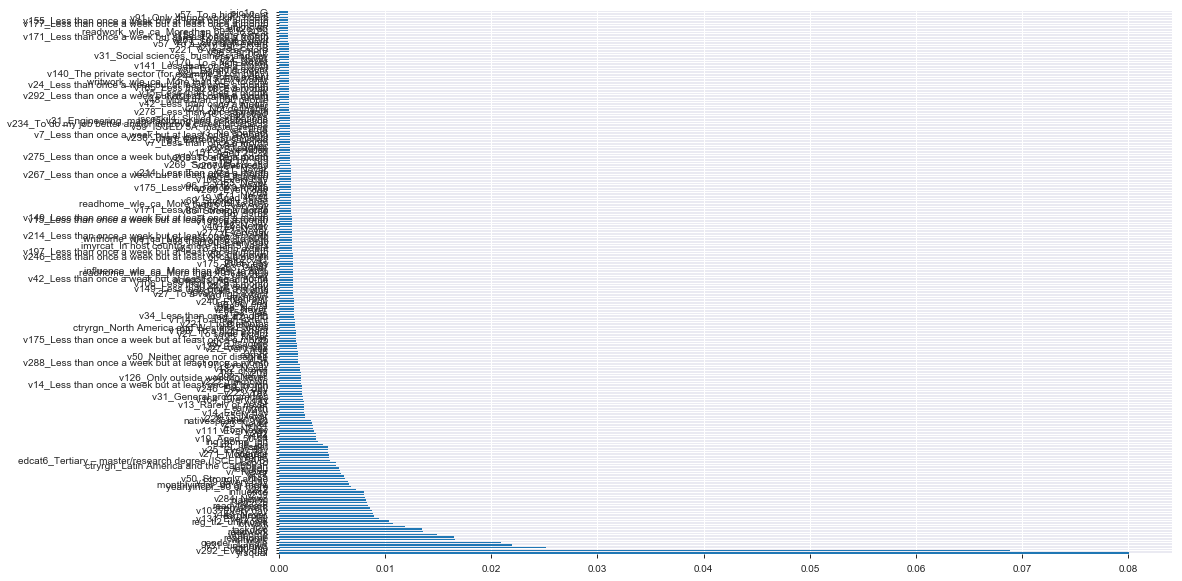

In [36]:
plt.figure(figsize=(16, 10))
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(205).plot(kind='barh')

### Detecting and removing weak features

In [39]:
# Since we have dummy variables we need to figure out unique important features

# creating new dataframe which show cumilative importance of all variables including dummies
df_cumus = pd.DataFrame({'total_var':np.cumsum(df_imp['importance'].values)})

# the number of variables which are able to explain 99% of variance
df_cumus.loc[df_cumus['total_var']>0.95].head(1)

,total_var
584,0.950138


In [ ]:
def underscore_split(list_):
    splitted_features = []
    
    for element in list_:
        triple = re.match(r'[\w+]+_[\w+]+_[\w+]+_[\w+]', element)
        double = re.match(r'[\w+]+_[\w+]+_[\w+]', element)
        single = re.match(r'[\w+]+_[\w+]', element)
        none = re.match(r'[\w+]', element)
    
        if triple:
            element = "_".join(element.split("_", 3)[:3])
        elif double:
            element = "_".join(element.split("_", 2)[:2])
        elif single:
            element = element.split("_")[0]
        else:
            element = element
    
        splitted_features.append(element)
    
    return splitted_features

In [40]:
# we know the number of all features with dummies for 95% variance. 584
# computing number of unique features with "underscore_split" function

imp95_features = list(df_imp[:584].index.values)
imp95_features = list(set(underscore_split(imp95_features)))
len(imp95_features)

236

In [41]:
# creating a new dataframe with detected important features
df = pd.concat([df[imp95_features], df['job_performance']], axis=1, sort=False)
df.shape

(20000, 237)

### Dropping additional features

In [42]:
# ageg10lfs_t is a recoding of ageg10lfs
# imyrs has 19283 (> 99.9%) zeros
# isco2c is highly correlated with isco1c
# v113 has 19458 (> 99.9%) zeros
# v184 is highly correlated with v104
# v194 has 18282 (91.4%) zeros
# v241 is highly correlated with v22
# v61 is highly correlated with v196
# v196 has 18021 (90.1%) zeros
# earnmthselfppp has 18781 (93.9%) zeros



drop_list_2 = ['ageg10lfs_t', 'imyrs', 'isco2c', 'v113', 'v184', 'v194', 'v241', 'v61', 'v196', 'earnmthselfppp']

df = df.drop(columns = drop_list_2, axis=1)

df.shape

(20000, 227)

### Checking distributions of numeric features

In [45]:
# All numerical columns distributions, discriptions and values analyzed 
# Zero values of Below columns need to be changed since they are considered as missing values

zero_to_fill_list = ['v104', 'earnmth', 'v210', 'earnhrppp', 'v22', 'earnhr']

for col in zero_to_fill_list:
    df[col]=df[col].replace(0,round(df[col].median()))

In [47]:
df_gd = pd.get_dummies(df, prefix_sep='_', drop_first=True)

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
X = df_gd.drop(['job_performance'], axis=1)
y = df_gd['job_performance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

rf = RandomForestRegressor(bootstrap=False, max_features=0.15000000000000002, min_samples_leaf=3,
                           min_samples_split=11, n_estimators=100, random_state = 0)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE:\n{}\n\nr2_score:\n{}'.format(mse, r2))

MSE:
33092.549065982465

r2_score:
0.8199944392638956


# AUTO_ML

#### Describing columns

In [48]:
column_descriptions = {
    'job_performance': 'output',
    'v142':'categorical', 'v180':'categorical', 'reg_tl2':'categorical', 'v166':'categorical',
    'v200':'categorical', 'readytolearn_wle_ca':'categorical', 'v103':'categorical', 'v138':'categorical',
    'iscoskil4':'categorical', 'v19':'categorical', 'nativespeaker':'categorical', 'v155':'categorical',
    'v92':'categorical', 'v251':'categorical', 'writwork_wle_ca':'categorical', 'v178':'categorical', 
    'v126':'categorical',
    'v282':'categorical', 'v57':'categorical', 'v8':'categorical', 'v221':'categorical', 'v15':'categorical',
    'v51':'categorical', 'v132':'categorical', 'v108':'categorical', 'v244':'categorical', 'v153':'categorical',
    'v274':'categorical', 'v289':'categorical', 'v12':'categorical', 'v250':'categorical', 'v233':'categorical',
    'v181':'categorical', 'v101':'categorical', 'writhome_wle_ca':'categorical', 'isic2c':'categorical',
    'v149':'categorical', 'faet12':'categorical', 'v26':'categorical', 'v285':'categorical', 'v13':'categorical',
    'v195':'categorical', 'v106':'categorical', 'edlevel3':'categorical', 'v292':'categorical', 'v91':'categorical',
    'v227':'categorical', 'v27':'categorical', 'isic1c':'categorical', 'v260':'categorical', 'v112':'categorical',
    'ctryrgn':'categorical', 'imyrs_c':'categorical', 'v247':'categorical', 'v93':'categorical', 
    'v216':'categorical', 'v114':'categorical', 'v73':'categorical', 'v237':'categorical', 'v118':'categorical',
    'v25':'categorical', 'v111':'categorical', 'v243':'categorical', 'v50':'categorical', 'v193':'categorical',
    'v141':'categorical', 'v171':'categorical', 'v123':'categorical', 'readhome_wle_ca':'categorical',
    'v28':'categorical', 'v40':'categorical', 'v189':'categorical', 'v157':'categorical', 'v188':'categorical',
    'v58':'categorical', 'fnfe12jr':'categorical', 'taskdisc_wle_ca':'categorical', 'v43':'categorical',
    'influence_wle_ca':'categorical', 'v48':'categorical', 'v69':'categorical', 'v17':'categorical',
    'earnflag':'categorical',
    'v280':'categorical', 'v288':'categorical', 'v158':'categorical', 'v102':'categorical', 'imyrcat':'categorical',
    'v223':'categorical', 'fnfaet12njr':'categorical', 'v263':'categorical', 'v190':'categorical',
    'v47':'categorical', 'v198':'categorical', 'v65':'categorical', 'v246':'categorical', 'v276':'categorical',
    'vet':'categorical', 'v137':'categorical', 'v265':'categorical', 'v261':'categorical', 
    'yearlyincpr':'categorical',
    'v255':'categorical', 'v269':'categorical', 'v284':'categorical', 'v204':'categorical', 'v162':'categorical',
    'v192':'categorical', 'v212':'categorical', 'v165':'categorical', 'gender_r':'categorical', 'v99':'categorical',
    'v151':'categorical', 'v140':'categorical', 'v2':'categorical', 'planning_wle_ca':'categorical',
    'fnfaet12jr':'categorical', 'v229':'categorical', 'v14':'categorical', 'v60':'categorical',
    'ageg5lfs':'categorical',
    'v31':'categorical', 'v191':'categorical', 'learnatwork_wle_ca':'categorical', 'earnmthalldcl':'categorical',
    'v208':'categorical', 'v24':'categorical', 'v291':'categorical', 'v7':'categorical', 'nfe12':'categorical',
    'v218':'categorical', 'v234':'categorical', 'v173':'categorical', 'v203':'categorical', 'v257':'categorical',
    'v42':'categorical', 'v240':'categorical', 'v278':'categorical', 'v96':'categorical', 'v168':'categorical',
    'v277':'categorical', 'v62':'categorical', 'v23':'categorical', 'v85':'categorical', 'v197':'categorical',
    'ageg10lfs':'categorical', 'v275':'categorical', 'v3':'categorical', 'fnfaet12':'categorical',
    'v225':'categorical', 'v34':'categorical', 'v53':'categorical', 'v134':'categorical', 'v175':'categorical',
    'lng_bq':'categorical', 'lng_home':'categorical', 'v271':'categorical', 'v266':'categorical',
    'v36':'categorical', 'v70':'categorical', 'v18':'categorical', 'v186':'categorical', 'v146':'categorical',
    'edcat6':'categorical', 'v214':'categorical', 'v29':'categorical', 'v267':'categorical', 'v139':'categorical',
    'lng_ci':'categorical', 'v222':'categorical', 'icthome_wle_ca':'categorical', 'v59':'categorical',
    'v77':'categorical', 'ictwork_wle_ca':'categorical', 'v177':'categorical', 'v82':'categorical',
    'v248':'categorical', 'v236':'categorical', 'v115':'categorical', 'readwork_wle_ca':'categorical',
    'v230':'categorical', 'monthlyincpr':'categorical', 'v170':'categorical', 'v131':'categorical',
    'v46':'categorical', 'v164':'categorical'
}

### Running the model with traning set

In [49]:
df_train, df_test = train_test_split(df, random_state =42, test_size = 0.25)

ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions=column_descriptions)

ml_predictor.train(df_train, model_names='LGBMRegressor',ml_for_analytics=True)

ml_predictor.score(df_test, df_test.job_performance)

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{'n_estimators': 2000, 'learning_rate': 0.15, 'num_leaves': 8, 'lambda_l2': 0.001, 'histogram_pool_size': 16384}
Running basic data cleaning
Fitting DataFrameVectorizer
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{'n_estimators': 2000, 'learning_rate': 0.15, 'num_leaves': 8, 'lambda_l2': 0.001, 'histogram_pool_size': 16384}


***************************************************************************************

[72]	random_holdout_set_from_training_data's rmse: 260.079	random_holdout_set_from_training_data's l2: 67641
[73]	random_holdout_set_from_training_data's rmse: 259.516	random_holdout_set_from_training_data's l2: 67348.5
[74]	random_holdout_set_from_training_data's rmse: 259.208	random_holdout_set_from_training_data's l2: 67188.6
[75]	random_holdout_set_from_training_data's rmse: 258.709	random_holdout_set_from_training_data's l2: 66930.3
[76]	random_holdout_set_from_training_data's rmse: 257.947	random_holdout_set_from_training_data's l2: 66536.6
[77]	random_holdout_set_from_training_data's rmse: 257.45	random_holdout_set_from_training_data's l2: 66280.3
[78]	random_holdout_set_from_training_data's rmse: 257.01	random_holdout_set_from_training_data's l2: 66054.1
[79]	random_holdout_set_from_training_data's rmse: 256.762	random_holdout_set_from_training_data's l2: 65926.7
[80]	random_holdout_set_from_training_data's rmse: 256.401	random_holdout_set_from_training_data's l2: 65741.5
[81]	

[155]	random_holdout_set_from_training_data's rmse: 235.138	random_holdout_set_from_training_data's l2: 55290.1
[156]	random_holdout_set_from_training_data's rmse: 235.016	random_holdout_set_from_training_data's l2: 55232.6
[157]	random_holdout_set_from_training_data's rmse: 234.767	random_holdout_set_from_training_data's l2: 55115.5
[158]	random_holdout_set_from_training_data's rmse: 234.622	random_holdout_set_from_training_data's l2: 55047.7
[159]	random_holdout_set_from_training_data's rmse: 234.444	random_holdout_set_from_training_data's l2: 54964.1
[160]	random_holdout_set_from_training_data's rmse: 234.245	random_holdout_set_from_training_data's l2: 54870.9
[161]	random_holdout_set_from_training_data's rmse: 234.198	random_holdout_set_from_training_data's l2: 54848.6
[162]	random_holdout_set_from_training_data's rmse: 233.967	random_holdout_set_from_training_data's l2: 54740.5
[163]	random_holdout_set_from_training_data's rmse: 233.766	random_holdout_set_from_training_data's l2: 

[249]	random_holdout_set_from_training_data's rmse: 218.006	random_holdout_set_from_training_data's l2: 47526.4
[250]	random_holdout_set_from_training_data's rmse: 217.91	random_holdout_set_from_training_data's l2: 47484.6
[251]	random_holdout_set_from_training_data's rmse: 217.843	random_holdout_set_from_training_data's l2: 47455.5
[252]	random_holdout_set_from_training_data's rmse: 217.716	random_holdout_set_from_training_data's l2: 47400.3
[253]	random_holdout_set_from_training_data's rmse: 217.543	random_holdout_set_from_training_data's l2: 47325.1
[254]	random_holdout_set_from_training_data's rmse: 217.488	random_holdout_set_from_training_data's l2: 47301
[255]	random_holdout_set_from_training_data's rmse: 217.554	random_holdout_set_from_training_data's l2: 47329.9
[256]	random_holdout_set_from_training_data's rmse: 217.419	random_holdout_set_from_training_data's l2: 47271.1
[257]	random_holdout_set_from_training_data's rmse: 217.231	random_holdout_set_from_training_data's l2: 471

[343]	random_holdout_set_from_training_data's rmse: 207.379	random_holdout_set_from_training_data's l2: 43005.9
[344]	random_holdout_set_from_training_data's rmse: 207.412	random_holdout_set_from_training_data's l2: 43019.6
[345]	random_holdout_set_from_training_data's rmse: 207.254	random_holdout_set_from_training_data's l2: 42954.1
[346]	random_holdout_set_from_training_data's rmse: 207.18	random_holdout_set_from_training_data's l2: 42923.4
[347]	random_holdout_set_from_training_data's rmse: 206.869	random_holdout_set_from_training_data's l2: 42794.7
[348]	random_holdout_set_from_training_data's rmse: 206.745	random_holdout_set_from_training_data's l2: 42743.5
[349]	random_holdout_set_from_training_data's rmse: 206.677	random_holdout_set_from_training_data's l2: 42715.4
[350]	random_holdout_set_from_training_data's rmse: 206.654	random_holdout_set_from_training_data's l2: 42706
[351]	random_holdout_set_from_training_data's rmse: 206.625	random_holdout_set_from_training_data's l2: 426

[435]	random_holdout_set_from_training_data's rmse: 199.427	random_holdout_set_from_training_data's l2: 39771
[436]	random_holdout_set_from_training_data's rmse: 199.524	random_holdout_set_from_training_data's l2: 39809.7
[437]	random_holdout_set_from_training_data's rmse: 199.503	random_holdout_set_from_training_data's l2: 39801.5
[438]	random_holdout_set_from_training_data's rmse: 199.504	random_holdout_set_from_training_data's l2: 39802
[439]	random_holdout_set_from_training_data's rmse: 199.471	random_holdout_set_from_training_data's l2: 39788.6
[440]	random_holdout_set_from_training_data's rmse: 199.342	random_holdout_set_from_training_data's l2: 39737.3
[441]	random_holdout_set_from_training_data's rmse: 199.276	random_holdout_set_from_training_data's l2: 39711.1
[442]	random_holdout_set_from_training_data's rmse: 199.178	random_holdout_set_from_training_data's l2: 39671.8
[443]	random_holdout_set_from_training_data's rmse: 199.166	random_holdout_set_from_training_data's l2: 3966

[531]	random_holdout_set_from_training_data's rmse: 194.323	random_holdout_set_from_training_data's l2: 37761.4
[532]	random_holdout_set_from_training_data's rmse: 194.2	random_holdout_set_from_training_data's l2: 37713.7
[533]	random_holdout_set_from_training_data's rmse: 194.007	random_holdout_set_from_training_data's l2: 37638.8
[534]	random_holdout_set_from_training_data's rmse: 193.971	random_holdout_set_from_training_data's l2: 37624.8
[535]	random_holdout_set_from_training_data's rmse: 193.932	random_holdout_set_from_training_data's l2: 37609.7
[536]	random_holdout_set_from_training_data's rmse: 193.855	random_holdout_set_from_training_data's l2: 37579.9
[537]	random_holdout_set_from_training_data's rmse: 193.802	random_holdout_set_from_training_data's l2: 37559.1
[538]	random_holdout_set_from_training_data's rmse: 193.673	random_holdout_set_from_training_data's l2: 37509.3
[539]	random_holdout_set_from_training_data's rmse: 193.665	random_holdout_set_from_training_data's l2: 37

[625]	random_holdout_set_from_training_data's rmse: 190.092	random_holdout_set_from_training_data's l2: 36134.8
[626]	random_holdout_set_from_training_data's rmse: 190.007	random_holdout_set_from_training_data's l2: 36102.8
[627]	random_holdout_set_from_training_data's rmse: 189.892	random_holdout_set_from_training_data's l2: 36058.8
[628]	random_holdout_set_from_training_data's rmse: 189.842	random_holdout_set_from_training_data's l2: 36040
[629]	random_holdout_set_from_training_data's rmse: 189.924	random_holdout_set_from_training_data's l2: 36071.2
[630]	random_holdout_set_from_training_data's rmse: 189.913	random_holdout_set_from_training_data's l2: 36067.1
[631]	random_holdout_set_from_training_data's rmse: 189.858	random_holdout_set_from_training_data's l2: 36046.2
[632]	random_holdout_set_from_training_data's rmse: 189.832	random_holdout_set_from_training_data's l2: 36036.1
[633]	random_holdout_set_from_training_data's rmse: 189.723	random_holdout_set_from_training_data's l2: 35

[723]	random_holdout_set_from_training_data's rmse: 186.987	random_holdout_set_from_training_data's l2: 34964.1
[724]	random_holdout_set_from_training_data's rmse: 186.991	random_holdout_set_from_training_data's l2: 34965.7
[725]	random_holdout_set_from_training_data's rmse: 186.885	random_holdout_set_from_training_data's l2: 34926.2
[726]	random_holdout_set_from_training_data's rmse: 186.815	random_holdout_set_from_training_data's l2: 34900
[727]	random_holdout_set_from_training_data's rmse: 186.736	random_holdout_set_from_training_data's l2: 34870.3
[728]	random_holdout_set_from_training_data's rmse: 186.703	random_holdout_set_from_training_data's l2: 34857.8
[729]	random_holdout_set_from_training_data's rmse: 186.579	random_holdout_set_from_training_data's l2: 34811.6
[730]	random_holdout_set_from_training_data's rmse: 186.539	random_holdout_set_from_training_data's l2: 34797
[731]	random_holdout_set_from_training_data's rmse: 186.503	random_holdout_set_from_training_data's l2: 3478

[815]	random_holdout_set_from_training_data's rmse: 183.893	random_holdout_set_from_training_data's l2: 33816.5
[816]	random_holdout_set_from_training_data's rmse: 183.859	random_holdout_set_from_training_data's l2: 33804
[817]	random_holdout_set_from_training_data's rmse: 183.76	random_holdout_set_from_training_data's l2: 33767.6
[818]	random_holdout_set_from_training_data's rmse: 183.709	random_holdout_set_from_training_data's l2: 33749
[819]	random_holdout_set_from_training_data's rmse: 183.678	random_holdout_set_from_training_data's l2: 33737.8
[820]	random_holdout_set_from_training_data's rmse: 183.661	random_holdout_set_from_training_data's l2: 33731.2
[821]	random_holdout_set_from_training_data's rmse: 183.632	random_holdout_set_from_training_data's l2: 33720.6
[822]	random_holdout_set_from_training_data's rmse: 183.574	random_holdout_set_from_training_data's l2: 33699.5
[823]	random_holdout_set_from_training_data's rmse: 183.547	random_holdout_set_from_training_data's l2: 33689

[911]	random_holdout_set_from_training_data's rmse: 181.462	random_holdout_set_from_training_data's l2: 32928.4
[912]	random_holdout_set_from_training_data's rmse: 181.437	random_holdout_set_from_training_data's l2: 32919.5
[913]	random_holdout_set_from_training_data's rmse: 181.402	random_holdout_set_from_training_data's l2: 32906.5
[914]	random_holdout_set_from_training_data's rmse: 181.382	random_holdout_set_from_training_data's l2: 32899.5
[915]	random_holdout_set_from_training_data's rmse: 181.367	random_holdout_set_from_training_data's l2: 32894
[916]	random_holdout_set_from_training_data's rmse: 181.398	random_holdout_set_from_training_data's l2: 32905.3
[917]	random_holdout_set_from_training_data's rmse: 181.388	random_holdout_set_from_training_data's l2: 32901.5
[918]	random_holdout_set_from_training_data's rmse: 181.369	random_holdout_set_from_training_data's l2: 32894.5
[919]	random_holdout_set_from_training_data's rmse: 181.324	random_holdout_set_from_training_data's l2: 32

[1008]	random_holdout_set_from_training_data's rmse: 179.453	random_holdout_set_from_training_data's l2: 32203.2
[1009]	random_holdout_set_from_training_data's rmse: 179.405	random_holdout_set_from_training_data's l2: 32186.1
[1010]	random_holdout_set_from_training_data's rmse: 179.342	random_holdout_set_from_training_data's l2: 32163.6
[1011]	random_holdout_set_from_training_data's rmse: 179.292	random_holdout_set_from_training_data's l2: 32145.6
[1012]	random_holdout_set_from_training_data's rmse: 179.257	random_holdout_set_from_training_data's l2: 32133.2
[1013]	random_holdout_set_from_training_data's rmse: 179.203	random_holdout_set_from_training_data's l2: 32113.8
[1014]	random_holdout_set_from_training_data's rmse: 179.182	random_holdout_set_from_training_data's l2: 32106.1
[1015]	random_holdout_set_from_training_data's rmse: 179.153	random_holdout_set_from_training_data's l2: 32095.8
[1016]	random_holdout_set_from_training_data's rmse: 179.098	random_holdout_set_from_training_da

[1103]	random_holdout_set_from_training_data's rmse: 177.354	random_holdout_set_from_training_data's l2: 31454.6
[1104]	random_holdout_set_from_training_data's rmse: 177.35	random_holdout_set_from_training_data's l2: 31453
[1105]	random_holdout_set_from_training_data's rmse: 177.313	random_holdout_set_from_training_data's l2: 31440
[1106]	random_holdout_set_from_training_data's rmse: 177.293	random_holdout_set_from_training_data's l2: 31432.6
[1107]	random_holdout_set_from_training_data's rmse: 177.349	random_holdout_set_from_training_data's l2: 31452.7
[1108]	random_holdout_set_from_training_data's rmse: 177.335	random_holdout_set_from_training_data's l2: 31447.6
[1109]	random_holdout_set_from_training_data's rmse: 177.342	random_holdout_set_from_training_data's l2: 31450.1
[1110]	random_holdout_set_from_training_data's rmse: 177.319	random_holdout_set_from_training_data's l2: 31442.1
[1111]	random_holdout_set_from_training_data's rmse: 177.319	random_holdout_set_from_training_data's 

[1201]	random_holdout_set_from_training_data's rmse: 176.232	random_holdout_set_from_training_data's l2: 31057.9
[1202]	random_holdout_set_from_training_data's rmse: 176.218	random_holdout_set_from_training_data's l2: 31052.8
[1203]	random_holdout_set_from_training_data's rmse: 176.215	random_holdout_set_from_training_data's l2: 31051.6
[1204]	random_holdout_set_from_training_data's rmse: 176.209	random_holdout_set_from_training_data's l2: 31049.8
[1205]	random_holdout_set_from_training_data's rmse: 176.222	random_holdout_set_from_training_data's l2: 31054.3
[1206]	random_holdout_set_from_training_data's rmse: 176.217	random_holdout_set_from_training_data's l2: 31052.4
[1207]	random_holdout_set_from_training_data's rmse: 176.211	random_holdout_set_from_training_data's l2: 31050.3
[1208]	random_holdout_set_from_training_data's rmse: 176.188	random_holdout_set_from_training_data's l2: 31042.4
[1209]	random_holdout_set_from_training_data's rmse: 176.198	random_holdout_set_from_training_da

[1301]	random_holdout_set_from_training_data's rmse: 175.261	random_holdout_set_from_training_data's l2: 30716.4
[1302]	random_holdout_set_from_training_data's rmse: 175.202	random_holdout_set_from_training_data's l2: 30695.6
[1303]	random_holdout_set_from_training_data's rmse: 175.219	random_holdout_set_from_training_data's l2: 30701.6
[1304]	random_holdout_set_from_training_data's rmse: 175.186	random_holdout_set_from_training_data's l2: 30690.3
[1305]	random_holdout_set_from_training_data's rmse: 175.197	random_holdout_set_from_training_data's l2: 30694.1
[1306]	random_holdout_set_from_training_data's rmse: 175.199	random_holdout_set_from_training_data's l2: 30694.8
[1307]	random_holdout_set_from_training_data's rmse: 175.194	random_holdout_set_from_training_data's l2: 30692.9
[1308]	random_holdout_set_from_training_data's rmse: 175.169	random_holdout_set_from_training_data's l2: 30684.2
[1309]	random_holdout_set_from_training_data's rmse: 175.175	random_holdout_set_from_training_da

[1393]	random_holdout_set_from_training_data's rmse: 174.345	random_holdout_set_from_training_data's l2: 30396
[1394]	random_holdout_set_from_training_data's rmse: 174.354	random_holdout_set_from_training_data's l2: 30399.3
[1395]	random_holdout_set_from_training_data's rmse: 174.347	random_holdout_set_from_training_data's l2: 30396.8
[1396]	random_holdout_set_from_training_data's rmse: 174.329	random_holdout_set_from_training_data's l2: 30390.7
[1397]	random_holdout_set_from_training_data's rmse: 174.334	random_holdout_set_from_training_data's l2: 30392.5
[1398]	random_holdout_set_from_training_data's rmse: 174.358	random_holdout_set_from_training_data's l2: 30400.9
[1399]	random_holdout_set_from_training_data's rmse: 174.324	random_holdout_set_from_training_data's l2: 30388.9
[1400]	random_holdout_set_from_training_data's rmse: 174.308	random_holdout_set_from_training_data's l2: 30383.2
[1401]	random_holdout_set_from_training_data's rmse: 174.295	random_holdout_set_from_training_data

[1493]	random_holdout_set_from_training_data's rmse: 173.629	random_holdout_set_from_training_data's l2: 30147.1
[1494]	random_holdout_set_from_training_data's rmse: 173.635	random_holdout_set_from_training_data's l2: 30149
[1495]	random_holdout_set_from_training_data's rmse: 173.645	random_holdout_set_from_training_data's l2: 30152.6
[1496]	random_holdout_set_from_training_data's rmse: 173.621	random_holdout_set_from_training_data's l2: 30144.3
[1497]	random_holdout_set_from_training_data's rmse: 173.604	random_holdout_set_from_training_data's l2: 30138.5
[1498]	random_holdout_set_from_training_data's rmse: 173.555	random_holdout_set_from_training_data's l2: 30121.5
[1499]	random_holdout_set_from_training_data's rmse: 173.536	random_holdout_set_from_training_data's l2: 30114.7
[1500]	random_holdout_set_from_training_data's rmse: 173.534	random_holdout_set_from_training_data's l2: 30114.1
[1501]	random_holdout_set_from_training_data's rmse: 173.544	random_holdout_set_from_training_data

[1586]	random_holdout_set_from_training_data's rmse: 172.81	random_holdout_set_from_training_data's l2: 29863.2
[1587]	random_holdout_set_from_training_data's rmse: 172.826	random_holdout_set_from_training_data's l2: 29868.8
[1588]	random_holdout_set_from_training_data's rmse: 172.802	random_holdout_set_from_training_data's l2: 29860.5
[1589]	random_holdout_set_from_training_data's rmse: 172.808	random_holdout_set_from_training_data's l2: 29862.5
[1590]	random_holdout_set_from_training_data's rmse: 172.802	random_holdout_set_from_training_data's l2: 29860.6
[1591]	random_holdout_set_from_training_data's rmse: 172.789	random_holdout_set_from_training_data's l2: 29856
[1592]	random_holdout_set_from_training_data's rmse: 172.845	random_holdout_set_from_training_data's l2: 29875.5
[1593]	random_holdout_set_from_training_data's rmse: 172.841	random_holdout_set_from_training_data's l2: 29873.9
[1594]	random_holdout_set_from_training_data's rmse: 172.845	random_holdout_set_from_training_data'

[1684]	random_holdout_set_from_training_data's rmse: 172.433	random_holdout_set_from_training_data's l2: 29733.2
[1685]	random_holdout_set_from_training_data's rmse: 172.434	random_holdout_set_from_training_data's l2: 29733.5
[1686]	random_holdout_set_from_training_data's rmse: 172.412	random_holdout_set_from_training_data's l2: 29726
[1687]	random_holdout_set_from_training_data's rmse: 172.409	random_holdout_set_from_training_data's l2: 29725
[1688]	random_holdout_set_from_training_data's rmse: 172.392	random_holdout_set_from_training_data's l2: 29718.8
[1689]	random_holdout_set_from_training_data's rmse: 172.372	random_holdout_set_from_training_data's l2: 29712.2
[1690]	random_holdout_set_from_training_data's rmse: 172.37	random_holdout_set_from_training_data's l2: 29711.3
[1691]	random_holdout_set_from_training_data's rmse: 172.362	random_holdout_set_from_training_data's l2: 29708.7
[1692]	random_holdout_set_from_training_data's rmse: 172.358	random_holdout_set_from_training_data's 

[1781]	random_holdout_set_from_training_data's rmse: 171.899	random_holdout_set_from_training_data's l2: 29549.3
[1782]	random_holdout_set_from_training_data's rmse: 171.903	random_holdout_set_from_training_data's l2: 29550.7
[1783]	random_holdout_set_from_training_data's rmse: 171.901	random_holdout_set_from_training_data's l2: 29549.8
[1784]	random_holdout_set_from_training_data's rmse: 171.905	random_holdout_set_from_training_data's l2: 29551.5
[1785]	random_holdout_set_from_training_data's rmse: 171.911	random_holdout_set_from_training_data's l2: 29553.5
[1786]	random_holdout_set_from_training_data's rmse: 171.975	random_holdout_set_from_training_data's l2: 29575.4
[1787]	random_holdout_set_from_training_data's rmse: 171.989	random_holdout_set_from_training_data's l2: 29580.2
[1788]	random_holdout_set_from_training_data's rmse: 171.982	random_holdout_set_from_training_data's l2: 29577.7
[1789]	random_holdout_set_from_training_data's rmse: 171.969	random_holdout_set_from_training_da

[1882]	random_holdout_set_from_training_data's rmse: 171.714	random_holdout_set_from_training_data's l2: 29485.9
[1883]	random_holdout_set_from_training_data's rmse: 171.703	random_holdout_set_from_training_data's l2: 29482
[1884]	random_holdout_set_from_training_data's rmse: 171.708	random_holdout_set_from_training_data's l2: 29483.7
[1885]	random_holdout_set_from_training_data's rmse: 171.701	random_holdout_set_from_training_data's l2: 29481.3
[1886]	random_holdout_set_from_training_data's rmse: 171.718	random_holdout_set_from_training_data's l2: 29487
[1887]	random_holdout_set_from_training_data's rmse: 171.706	random_holdout_set_from_training_data's l2: 29483
[1888]	random_holdout_set_from_training_data's rmse: 171.703	random_holdout_set_from_training_data's l2: 29481.9
[1889]	random_holdout_set_from_training_data's rmse: 171.709	random_holdout_set_from_training_data's l2: 29484
[1890]	random_holdout_set_from_training_data's rmse: 171.694	random_holdout_set_from_training_data's l2:

[1978]	random_holdout_set_from_training_data's rmse: 171.454	random_holdout_set_from_training_data's l2: 29396.5
[1979]	random_holdout_set_from_training_data's rmse: 171.456	random_holdout_set_from_training_data's l2: 29397.1
[1980]	random_holdout_set_from_training_data's rmse: 171.452	random_holdout_set_from_training_data's l2: 29395.9
[1981]	random_holdout_set_from_training_data's rmse: 171.445	random_holdout_set_from_training_data's l2: 29393.5
[1982]	random_holdout_set_from_training_data's rmse: 171.438	random_holdout_set_from_training_data's l2: 29391.1
[1983]	random_holdout_set_from_training_data's rmse: 171.435	random_holdout_set_from_training_data's l2: 29390.1
[1984]	random_holdout_set_from_training_data's rmse: 171.447	random_holdout_set_from_training_data's l2: 29393.9
[1985]	random_holdout_set_from_training_data's rmse: 171.456	random_holdout_set_from_training_data's l2: 29397
[1986]	random_holdout_set_from_training_data's rmse: 171.443	random_holdout_set_from_training_data

None


***********************************************
Advanced scoring metrics for the trained regression model on this particular dataset:

Here is the overall RMSE for these predictions:
166.47416486447094

Here is the average of the predictions:
2907.6247245281315

Here is the average actual value on this validation set:
2909.5394274109203

Here is the median prediction:
2934.802485027927

Here is the median actual value:
2940.41165812164

Here is the mean absolute error:
77.65978378984786

Here is the median absolute error (robust to outliers):
12.522914575203231

Here is the explained variance:
0.8459358679227216

Here is the R-squared value:
0.8459154849234723
Count of positive differences (prediction > actual):
2451
Count of negative differences:
2549
Average positive difference:
77.25936445028157
Average negative difference:
-78.04480842746149


***********************************************




-166.47416486447094

### Evaluating auto_ml model with MSE score of traning set

In [51]:
# Here is the overall RMSE for these predictions:
# 166.47416486447094

# Calculating MSE score
print("\nMSE (auto_ml):\n{}".format(int((166.47416486447094**2))))


MSE (auto_ml):
27713


## Predicting on test set

In [60]:
df_test_org = pd.read_csv('client-testset-1561457457-252.csv')
df_test = df_test_org[imp95_features].drop(columns = drop_list_2, axis=1)
df_test.shape

(20000, 226)

### Data wrangling for test set: same steps

In [62]:
# Seperating numeric and categorical features

categorical_clms = df_test.select_dtypes(include=['O']).columns
print("Number of categorical columns: {}".format(len(categorical_clms)))

numerical_clms = df_test.select_dtypes(include=['int64', 'float64']).columns
print("Number of numerical columns: {}".format(len(numerical_clms)))

df_cat = pd.DataFrame(df_test, columns=categorical_clms)
df_num = pd.DataFrame(df_test, columns=numerical_clms)

# replacing outliers with median
for feature in df_num.keys():
    step=1.5*((np.percentile(df_num[feature], q=75))-(np.percentile(df_num[feature], q=25)))
    lower_bound=(np.percentile(df_num[feature], q=25))-step
    upper_bound=(np.percentile(df_num[feature], q=75))+step
    median = round(df_num[feature].median())
    df_num[feature][df_num[feature]<lower_bound] = median
    df_num[feature][df_num[feature]>upper_bound] = median

# filling NaN values with median (because some variables are highly skewed and also some are related with years)
df_num = df_num.fillna(0)

for col in df_num.columns:
    df_num[col]=df_num[col].replace(0,round(df_num[col].median()))

# filling categorical missing with value of "unknown"
df_cat = df_cat.fillna('unknown')

# concatenating both dataframes again
df_test = pd.concat([df_num, df_cat], axis=1, sort=False)

# now we have a %100 filled dataframe
df_test.head(2)

Number of categorical columns: 186
Number of numerical columns: 40


,v136,nfehrsjr,v210,v105,v33,planning,nfehrsnjr,v252,writhome,v187,...,v175,isic1c,v292,v203,v171,v3,v57,fnfe12jr,v112,gender_r
0,0.0,24.0,0.0,9996.0,1.0,1.561355,0.0,0.0,2.75416,0.0,...,Never,C,Less than once a week but at least once a month,Other,Less than once a month,unknown,To a high extent,Participated in FE or NFE for JR reasons,unknown,Female
1,0.0,0.0,0.0,9996.0,1.0,1.958027,0.0,0.0,2.00000,0.0,...,unknown,G,Every day,unknown,Never,unknown,To some extent,Did not participate in FE or NFE for JR reasons,unknown,Male


#### Saving the model

In [52]:
ml_predictor.save(file_name='auto_ml_saved_pipeline.dill', verbose=True)



We have saved the trained pipeline to a filed called "auto_ml_saved_pipeline.dill"
It is saved in the directory: 
/Users/hy/Documents/05_Upwork/job_performance
To use it to get predictions, please follow the following flow (adjusting for your own uses as necessary:


`from auto_ml.utils_models import load_ml_model
`trained_ml_pipeline = load_ml_model("auto_ml_saved_pipeline.dill")
`trained_ml_pipeline.predict(data)`


Note that this pickle/dill file can only be loaded in an environment with the same modules installed, and running the same Python version.
This version of Python is:
sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)


When passing in new data to get predictions on, columns that were not present (or were not found to be useful) in the training data will be silently ignored.
It is worthwhile to make sure that you feed in all the most useful data points though, to make sure you can get the highest quality predictions.


'/Users/hy/Documents/05_Upwork/job_performance/auto_ml_saved_pipeline.dill'

### Predicting on test_set and saving the results

In [63]:
from auto_ml.utils_models import load_ml_model
trained_ml_pipeline = load_ml_model("auto_ml_saved_pipeline.dill")

In [64]:
y_pred_aml = trained_ml_pipeline.predict(df_test)

In [66]:
df_y_pred_aml = pd.DataFrame(y_pred_aml) 
df_y_pred_aml.to_csv('predictions.csv', sep=',', encoding='utf-8', index=False)

# CONCLUSION